In [22]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../../")

import numpy as np

%matplotlib widget

In [23]:
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from weyl_decompose import RootiSwapWeylDecomposition as decomposer
from qiskit.transpiler.passes import Collect2qBlocks, ConsolidateBlocks, Unroll3qOrMore, Optimize1qGates
from src.utils.custom_gates import RiSwapGate
from qiskit.circuit.library import CXGate
from qiskit.converters import circuit_to_dag
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator
from src.basis import MixedOrderBasisCircuitTemplate
from src.utils.polytope_wrap import monodromy_range_from_target
from src.scripts.gate_exploration.bgatev2script import get_group_name, cost_scaling, pick_winner
from qiskit.transpiler.basepasses import AnalysisPass
from qiskit.transpiler.passes import CountOps
from qiskit.dagcircuit import DAGOpNode, DAGCircuit
from qiskit.transpiler import PassManager

In [24]:
# main TODO summary:
# passes arent doing any swap things yet
# not finding a basis gate between each qubit pair after swap pass

In [25]:
from qiskit.circuit.library import QuantumVolume, QFT
qc = QuantumVolume(16, depth=64).decompose()
qc = QFT(16).decompose()
duration_1q = .25

In [26]:
# looking for some way to more directly use transpiler optimization level 3
# can use the same pass manager configuration for layout and routing?
# then change to custom once we get to the gate translation

In [27]:
class fooAnalysis(AnalysisPass):
    """print duration of the circuit (iswap = 1 unit)"""
    def run(self, dag):
        d = 0 #tracking critical path duration
        for gate in dag.longest_path():
            if isinstance(gate, DAGOpNode):
                d += gate.op.duration if gate.op.duration is not None else 0
                if gate.op.name in ['u', 'u1', 'u2', 'u3']:
                    d += duration_1q
                if gate.op.name in ['cx']:
                    d += 1
        self.property_set['duration'] = d

In [28]:
class pass_manager_basic(PassManager):
    def __init__(self, gate='iswap'):
        passes = []
        # collect 2Q blocks
        passes.extend([Unroll3qOrMore(), Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)])
        if gate == 'iswap':
            passes.extend([decomposer(basis_gate=RiSwapGate(1/2))])
        elif gate == 'cx':
            passes.extend([decomposer(basis_gate=CXGate())])
        #combine 1Q gates
        passes.extend([Optimize1qGates()])
        passes.extend([CountOps(), fooAnalysis()])
        super().__init__(passes)

In [29]:
class SpeedGateSubstitute(TransformationPass):
    def __init__(self, speed_method='linear', duration_1q=0, strategy='basic_overall'):
        super().__init__()
        
        self.speed_method = speed_method
        self.duration_1q = duration_1q
        self.strategy = strategy

        # makes sure the data exists first
        cost_scaling(speed_method=speed_method, duration_1q=duration_1q)
        self.group_name = get_group_name(speed_method, duration_1q)

    def run(self, dag: DAGCircuit):
        """Run the pass on `dag`."""

        if self.strategy == 'basic_overall':
            """Here, we define a single metric to pick a winner gate to be used for all decompositions
            Metrics pick most efficient for either SWAP, CNOT, or Haar"""
            w = pick_winner(self.group_name, metric=0)
            #that way we only have to compute a single coverage set
            template = MixedOrderBasisCircuitTemplate(base_gates=[w])
            
            logging.info("Found winner, begin substitution")

            #second, make substitutions
            for node in dag.two_qubit_ops():
                target = Operator(node.op).data

                reps = monodromy_range_from_target(template, target_u =target)[0] 
                
                template.build(reps)
                #we should set all the U3 gates to be real valued - doesn't matter for sake of counting duration
                sub_qc = template.assign_Xk(template.parameter_guess())
                sub_dag = circuit_to_dag(sub_qc)
                dag.substitute_node_with_dag(node, sub_dag)

        elif self.strategy == 'weighted_overall':
            """Here, we are counting gates that appear in the circuit in order to define a winner metric"""
            #first, need frqeuncy of each gate
            # NOTE this feels unoptimized, because we are consolidating 1Q gates, so more misses (?)
            target_ops = [g.op for g in dag.two_qubit_ops()]
            w = pick_winner(self.group_name, metric=-1, target_ops=target_ops)
            logging.info("Found winner, begin substitution")

            template = MixedOrderBasisCircuitTemplate(base_gates=[w])

            #second, make substitutions
            for node in dag.two_qubit_ops():
                target = Operator(node.op).data

                reps = monodromy_range_from_target(template, target_u =target)[0] 
                
                template.build(reps)
                #we should set all the U3 gates to be real valued - doesn't matter for sake of counting duration
                sub_qc = template.assign_Xk(template.parameter_guess())
                sub_dag = circuit_to_dag(sub_qc)
                dag.substitute_node_with_dag(node, sub_dag)

        elif self.strategy == 'weighted_pairwise':
            """Here, we count gates that appear between each pair of qubits in the circuit, define a winner for each pair"""
            raise NotImplementedError("weighted_pairwise not implemented yet")

            # w = d.qubits #if use wires error bc returns classical bits
            # qubit_wire_counts = np.zeros(20)
            # for i, wi in enumerate(w):
            #     for node in d.nodes_on_wire(wi, only_ops=True):
            #         if node.name in ignore:
            #             continue
            #         if node.name == 'cx':
            #             qubit_wire_counts[i] += 1
        else:
            raise ValueError("Strategy not recognized")

        logging.warning("1Q gates are not being set to accurate values, just placeholders for fast counting")
        return dag 

#speed-limit aware manager
class pass_manager_slam(PassManager):
    def __init__(self, strategy='basic_overall', speed_method='linear', duration_1q=0):
        passes = []
        # collect 2Q blocks
        passes.extend([Unroll3qOrMore(), Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)])
        passes.extend([SpeedGateSubstitute(strategy=strategy, speed_method=speed_method, duration_1q=duration_1q)])
        #combine 1Q gates
        passes.extend([Optimize1qGates()])
        passes.extend([CountOps(), fooAnalysis()])
        super().__init__(passes)

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 0.07033 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 0.44703 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 90.49177 (ms)
INFO:root:winner: 2QGate(0.07853982, 0.70685835, 1.00000000), scores: [1.76947394 1.65795455 3.06590909], cost: 0.5
INFO:root:Found winner, begin substitution
INFO:qiskit.transpiler.runningpassmanager:Pass: SpeedGateSubstitute - 483.63614 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 125.18263 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.02456 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: fooAnalysis - 0.49639 (ms)


Transpilation Results:
{'2QGate': 272, 'u3': 560}
46.75


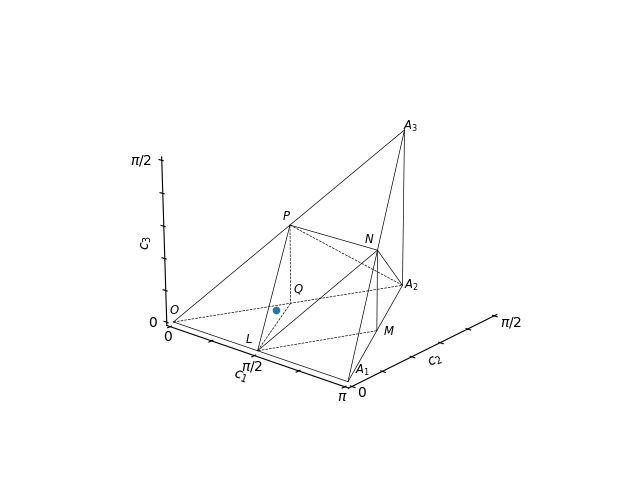

In [35]:
method = ['linear', 'mid', 'squared', 'hardware'][2]
strategy = ['basic_overall', 'weighted_overall', 'weighted_pairwise'][0]
pm = pass_manager_slam(strategy=strategy, speed_method=method, duration_1q=duration_1q)
transp0 = pm.run(qc)
print("Transpilation Results:")
print(pm.property_set['count_ops'])
print(pm.property_set['duration'])

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 0.07415 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 0.54431 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 91.19892 (ms)
100%|██████████| 176/176 [00:19<00:00,  9.08it/s]
INFO:root:winner: 2QGate(0.05890486, 0.23561945, 1.00000000), scores: [2.51743586 2.67667526 4.29445876], cost: 0.18750000000000003
INFO:root:Found winner, begin substitution
INFO:qiskit.transpiler.runningpassmanager:Pass: SpeedGateSubstitute - 19882.86352 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 139.65154 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.02337 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: fooAnalysis - 0.71836 (ms)


Transpilation Results:
{'2QGate': 335, 'u3': 686}
36.5625


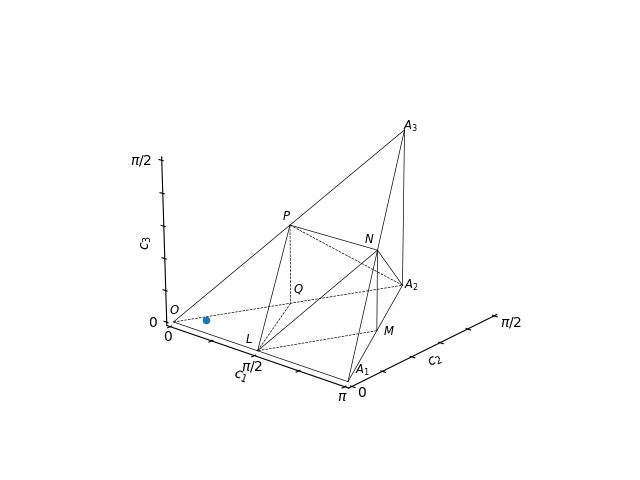

In [34]:
method = ['linear', 'mid', 'squared', 'hardware'][2]
strategy = ['basic_overall', 'weighted_overall', 'weighted_pairwise'][1]
pm = pass_manager_slam(strategy=strategy, speed_method=method, duration_1q=duration_1q)
transp0 = pm.run(qc)
print("Transpilation Results:")
print(pm.property_set['count_ops'])
print(pm.property_set['duration'])

In [9]:
#transp1 = transpile(qc, optimization_level=3, basis_gates=['u', 'id', 'cx'])
pm = pass_manager_basic(gate='iswap')
transp1 = pm.run(qc)
print("Transpilation Results:")
print(pm.property_set['count_ops'])
print(pm.property_set['duration'])

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 1.65272 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 15.40780 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 2290.62009 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RootiSwapWeylDecomposition - 19917.13524 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 6299.46351 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.02670 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: fooAnalysis - 9.65881 (ms)


Transpilation Results:
{'u3': 17906, 'riswap': 8921}
256.0


In [ ]:
#transp1 = transpile(qc, optimization_level=3, basis_gates=['u', 'id', 'cx'])
pm = pass_manager_basic(gate='cx')
transp1 = pm.run(qc)
print("Transpilation Results:")
print(pm.property_set['count_ops'])
print(pm.property_set['duration'])

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 1.78623 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 16.25514 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 2243.75939 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RootiSwapWeylDecomposition - 11573.43984 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 7393.95809 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.02503 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: fooAnalysis - 12.40945 (ms)


Transpilation Results:
{'u3': 24238, 'cx': 12087}
384


In [ ]:
#TODO want to print duration comparing
# analytical riswap(2) kak decomp
# speed limited linear vs characterized
# speed limited with 1q gates counting
# approx riswap(2) kak decomp (noise-aware)
# all-to-all (noswap) vs square lattice

In [ ]:
# noisy simulation to calculate QV
# use a QV that includes random gates all over weyl chamber

In [ ]:
#transpiler count gates over other benchmarks

In [ ]:
# add a metric which considers the cnot score is some amount good
# this takes into account that riswap guarantees to be as good as cx

# find the best gate that works for both: best haar score that builds cnot with score as good as current gate.

In [ ]:
# can we come up with an analytical/proof relating gates to work for cnot

In [ ]:
#1. cost params
#2  winner function
#3. circuit -> report qv/duration percent